In [1]:
# Data Handling
import pandas as pd
import numpy as np

# Date & Time
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Modeling
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
train_df = pd.read_csv(r"C:\Users\ajayr\Downloads\Dataset\train.csv",parse_dates=['Date'])
test_df = pd.read_csv(r"C:\Users\ajayr\Downloads\Dataset\test.csv",parse_dates=['Date'])
store_df = pd.read_csv(r"C:\Users\ajayr\Downloads\Dataset\store.csv")

C:\Users\ajayr\AppData\Local\Temp\ipykernel_11000\4240521319.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(r"C:\Users\ajayr\Downloads\Dataset\train.csv",parse_dates=['Date'])


In [3]:
# Fill Missing Values in store_df
store_df['CompetitionDistance'] = store_df['CompetitionDistance'].fillna(store_df['CompetitionDistance'].median())
store_df['CompetitionOpenSinceMonth'] = store_df['CompetitionOpenSinceMonth'].fillna(0)
store_df['CompetitionOpenSinceYear'] = store_df['CompetitionOpenSinceYear'].fillna(0)
store_df['Promo2SinceWeek'] = store_df['Promo2SinceWeek'].fillna(0)
store_df['Promo2SinceYear'] = store_df['Promo2SinceYear'].fillna(0)
store_df['PromoInterval'] = store_df['PromoInterval'].astype('category')
store_df['PromoInterval'] = store_df['PromoInterval'].cat.add_categories(['None']).fillna('None')




In [4]:
# Fill Missing Values in test_df
test_df['Open'] = test_df['Open'].fillna(1)


In [5]:
# Merge Store Info into Train and Test
train_df = pd.merge(train_df, store_df, on='Store', how='left')
test_df = pd.merge(test_df, store_df, on='Store', how='left')


In [6]:
# Combine Train and Test for Feature Engineering
train_df['is_train'] = 1
test_df['is_train'] = 0
test_df['Sales'] = np.nan
full_df = pd.concat([train_df, test_df], sort=False).sort_values(['Store', 'Date'])


In [7]:
# Create Date-Based Feature
full_df['Year'] = full_df['Date'].dt.year
full_df['Week'] = full_df['Date'].dt.isocalendar().week
full_df['Month'] = full_df['Date'].dt.strftime('%b')
full_df['MonthName'] = full_df['Date'].dt.strftime('%b')



In [8]:
# Create Promo2Active Flag
full_df['MonthInPromoInterval'] = full_df.apply(
    lambda row: row['Month'] in row['PromoInterval'].split(', ') if row['PromoInterval'] else False,
    axis=1
)

full_df['Promo2Active'] = full_df.apply(lambda row: (
    row['Promo2'] == 1 and (
        (row['Year'] > row['Promo2SinceYear']) or
        (row['Year'] == row['Promo2SinceYear'] and row['Week'] >= row['Promo2SinceWeek'])
    ) and row['MonthInPromoInterval']
), axis=1)


In [9]:
# Create CompetitionOpenMonths Feature
full_df['CompetitionOpenDate'] = pd.to_datetime(dict(
    year=full_df['CompetitionOpenSinceYear'],
    month=full_df['CompetitionOpenSinceMonth'],
    day=1
), errors='coerce')

full_df['CompetitionOpenMonths'] = (
    (full_df['Date'].dt.year - full_df['CompetitionOpenDate'].dt.year) * 12 +
    (full_df['Date'].dt.month - full_df['CompetitionOpenDate'].dt.month)
).clip(lower=0).fillna(0)


In [10]:
# Encode StateHoliday
full_df['StateHoliday'] = full_df['StateHoliday'].astype(str).str.strip()
holiday_map = {'0': 0, 'a': 1, 'b': 2, 'c': 3}
full_df['StateHolidayEncoded'] = full_df['StateHoliday'].map(holiday_map).fillna(0).astype(int)


In [11]:
# Create Lag and Rolling Feature
full_df = full_df.sort_values(by=["Store", "Date"])
full_df["Rolling_4W"] = full_df.groupby("Store")["Sales"].shift(1).rolling(window=4).mean()

full_df['lag_1'] = full_df.groupby('Store')['Sales'].shift(1)
full_df['lag_7'] = full_df.groupby('Store')['Sales'].shift(7)
full_df['lag_14'] = full_df.groupby('Store')['Sales'].shift(14)
full_df['lag_30'] = full_df.groupby('Store')['Sales'].shift(30)

full_df['roll_mean_7'] = full_df.groupby('Store')['Sales'].shift(1).rolling(window=7).mean()
full_df['roll_mean_14'] = full_df.groupby('Store')['Sales'].shift(1).rolling(window=14).mean()
full_df['roll_mean_30'] = full_df.groupby('Store')['Sales'].shift(1).rolling(window=30).mean()


In [12]:
# Additional Time Features
full_df['Day'] = full_df['Date'].dt.day
full_df['IsWeekend'] = full_df['Date'].dt.dayofweek.isin([5, 6])
full_df['expanding_mean'] = full_df.groupby('Store')['Sales'].expanding().mean().reset_index(level=0, drop=True)


In [13]:
# Rebuild Train and Test Sets
train_df = full_df[full_df['is_train'] == 1].copy()
test_df = full_df[full_df['is_train'] == 0].copy()

train_df = train_df.dropna(subset=[
    'lag_1', 'lag_7', 'lag_14', 'lag_30',
    'roll_mean_7', 'roll_mean_14', 'roll_mean_30'
])


In [14]:
#  Time-Based Train/Validation Split
valid_start_date = '2015-06-01'
train_data = train_df[train_df['Date'] < valid_start_date]
valid_data = train_df[train_df['Date'] >= valid_start_date]


In [15]:
#  Define Feature List
features = [
    'Store', 'DayOfWeek', 'Open', 'Promo', 'StateHolidayEncoded', 'SchoolHoliday',
    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear',
    'PromoInterval', 'Month', 'MonthInPromoInterval', 'Promo2Active', 'Rolling_4W',
    'lag_1', 'lag_7', 'lag_14', 'lag_30', 'roll_mean_7', 'roll_mean_14', 'roll_mean_30',
    'Day', 'IsWeekend', 'expanding_mean'
]


In [16]:
# Prepare Training and Validation Data
X_train = train_data[features].copy()
y_train = train_data['Sales']
X_valid = valid_data[features].copy()
y_valid = valid_data['Sales']


In [17]:
# Label Encode Categorical Columns
X_train_enc = X_train.copy()
X_valid_enc = X_valid.copy()
cat_cols = X_train_enc.select_dtypes(include=['category', 'object']).columns

for col in cat_cols:
    X_train_enc[col] = X_train_enc[col].astype(str)
    X_valid_enc[col] = X_valid_enc[col].astype(str)
    le = LabelEncoder()
    combined = pd.concat([X_train_enc[col], X_valid_enc[col]], axis=0)
    le.fit(combined)
    X_train_enc[col] = le.transform(X_train_enc[col])
    X_valid_enc[col] = le.transform(X_valid_enc[col])


In [18]:
# Train XGBoost Model
import xgboost as xgb

# Convert your training and validation sets to DMatrix
dtrain = xgb.DMatrix(X_train_enc, label=y_train)
dvalid = xgb.DMatrix(X_valid_enc, label=y_valid)

# Define model parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 6,
    'seed': 42
}

# Train the model with evaluation
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,
    evals=[(dvalid, 'validation')]
)



[0]	validation-rmse:3475.32670
[1]	validation-rmse:3165.11706
[2]	validation-rmse:2888.50402
[3]	validation-rmse:2641.84207
[4]	validation-rmse:2421.80666
[5]	validation-rmse:2224.96604
[6]	validation-rmse:2048.66508
[7]	validation-rmse:1893.98035
[8]	validation-rmse:1756.39180
[9]	validation-rmse:1635.08678
[10]	validation-rmse:1527.41659
[11]	validation-rmse:1435.89951
[12]	validation-rmse:1353.75938
[13]	validation-rmse:1282.44863
[14]	validation-rmse:1220.62185
[15]	validation-rmse:1165.61921
[16]	validation-rmse:1119.10211
[17]	validation-rmse:1077.03573
[18]	validation-rmse:1042.27849
[19]	validation-rmse:1013.03778
[20]	validation-rmse:988.04329
[21]	validation-rmse:967.64059
[22]	validation-rmse:948.76415
[23]	validation-rmse:931.65119
[24]	validation-rmse:920.11106
[25]	validation-rmse:911.60369
[26]	validation-rmse:900.83990
[27]	validation-rmse:893.69083
[28]	validation-rmse:886.86348
[29]	validation-rmse:880.52559
[30]	validation-rmse:875.93559
[31]	validation-rmse:871.6263

In [19]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Predict on validation set
y_valid_pred = model.predict(xgb.DMatrix(X_valid_enc))

# Calculate metrics
mae = mean_absolute_error(y_valid, y_valid_pred)
mape = mean_absolute_percentage_error(y_valid, y_valid_pred) * 100  # %

print(f"Validation MAE: {mae:.2f}")
print(f"Validation MAPE: {mape:.2f}%")

Validation MAE: 530.55
Validation MAPE: 2307050825515604992.00%


In [20]:
# Generate Final Predictions for Submission

In [21]:
# Prepare Test Data 
test_features = test_df[features].copy()




In [22]:
# Label Encode Categorical Columns 
for col in test_features.select_dtypes(include=['category', 'object']).columns:
    # Convert both train and test column to string
    X_train_enc[col] = X_train_enc[col].astype(str)
    test_features[col] = test_features[col].astype(str)

    # Combine and encode
    combined = pd.concat([X_train_enc[col], test_features[col]], axis=0).astype(str)
    le = LabelEncoder()
    le.fit(combined)

    # Transform
    test_features[col] = le.transform(test_features[col])




In [23]:
# Forecast vs Actual Plot for a Sample Store

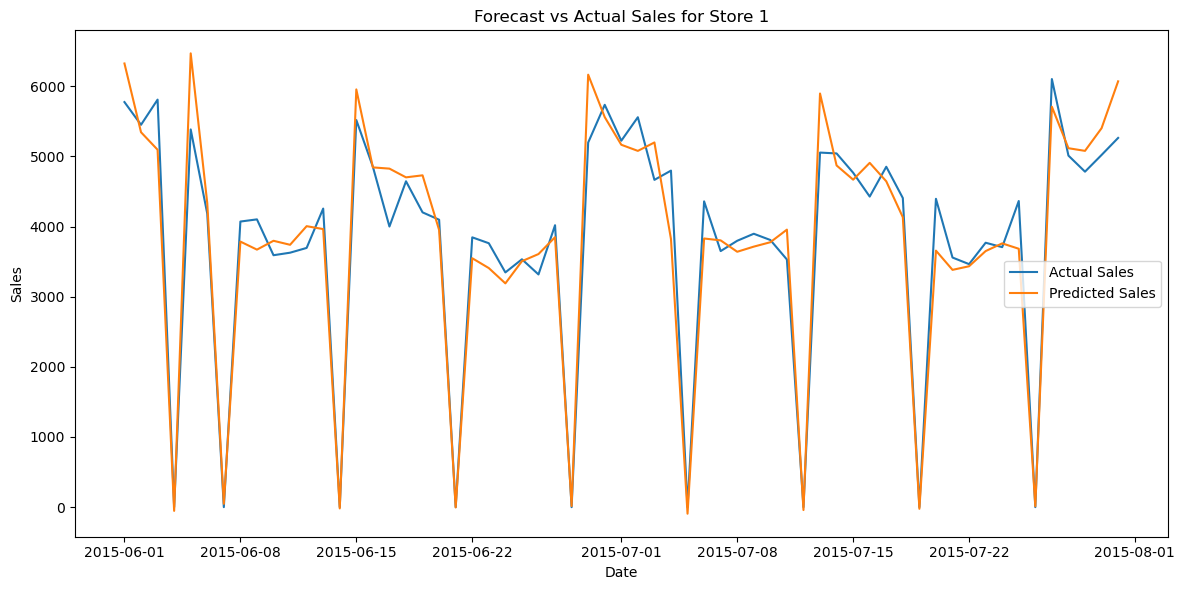

In [24]:
# Choose a sample store
sample_store = valid_data['Store'].iloc[0]
sample_valid = valid_data[valid_data['Store'] == sample_store].copy()
sample_valid = sample_valid.sort_values('Date')

# Encode and predict
sample_X = sample_valid[features].copy()
for col in sample_X.select_dtypes(include=['category', 'object']).columns:
    sample_X[col] = sample_X[col].astype(str)
    le = LabelEncoder()
    combined = pd.concat([X_train_enc[col], sample_X[col]], axis=0)
    le.fit(combined)
    sample_X[col] = le.transform(sample_X[col])

sample_valid['Predicted_Sales'] = model.predict(xgb.DMatrix(sample_X))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(sample_valid['Date'], sample_valid['Sales'], label='Actual Sales')
plt.plot(sample_valid['Date'], sample_valid['Predicted_Sales'], label='Predicted Sales')
plt.title(f"Forecast vs Actual Sales for Store {sample_store}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.savefig("forecast_vs_actual.png", dpi=300)
plt.show()

In [25]:
# Convert to DMatrix
dtest = xgb.DMatrix(test_features)

# Predict
test_df['Sales'] = model.predict(dtest)

# Format for Submission
submission = test_df[['Id', 'Sales']].copy()
submission['Sales'] = submission['Sales'].clip(lower=0)  # Optional: avoid negative sales

# Save to CSV
submission.to_csv('submission.csv', index=False)
print("✅ Submission file saved as 'submission.csv'")

✅ Submission file saved as 'submission.csv'


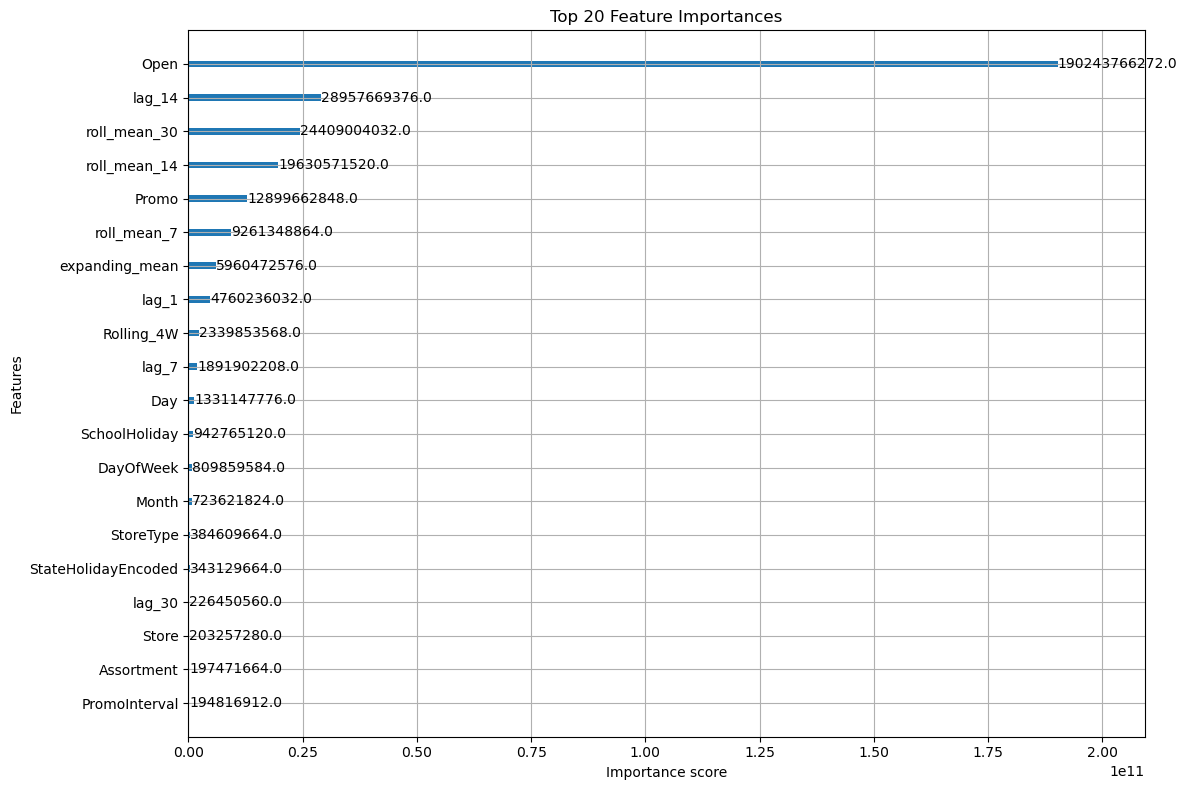

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(model, ax=ax, max_num_features=20, importance_type='gain')
ax.set_title("Top 20 Feature Importances")
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=300)
plt.show()

In [27]:
# Visualize Feature Importance

<Figure size 1200x800 with 0 Axes>

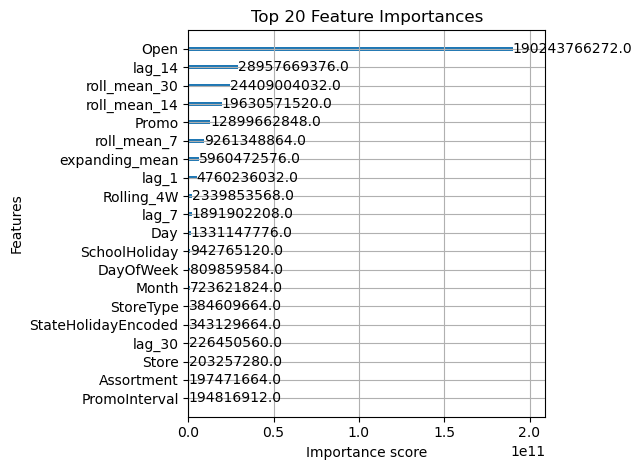

In [28]:
#  Feature Importance Plot ---
import matplotlib.pyplot as plt
import xgboost as xgb

plt.figure(figsize=(12, 8))
xgb.plot_importance(model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()


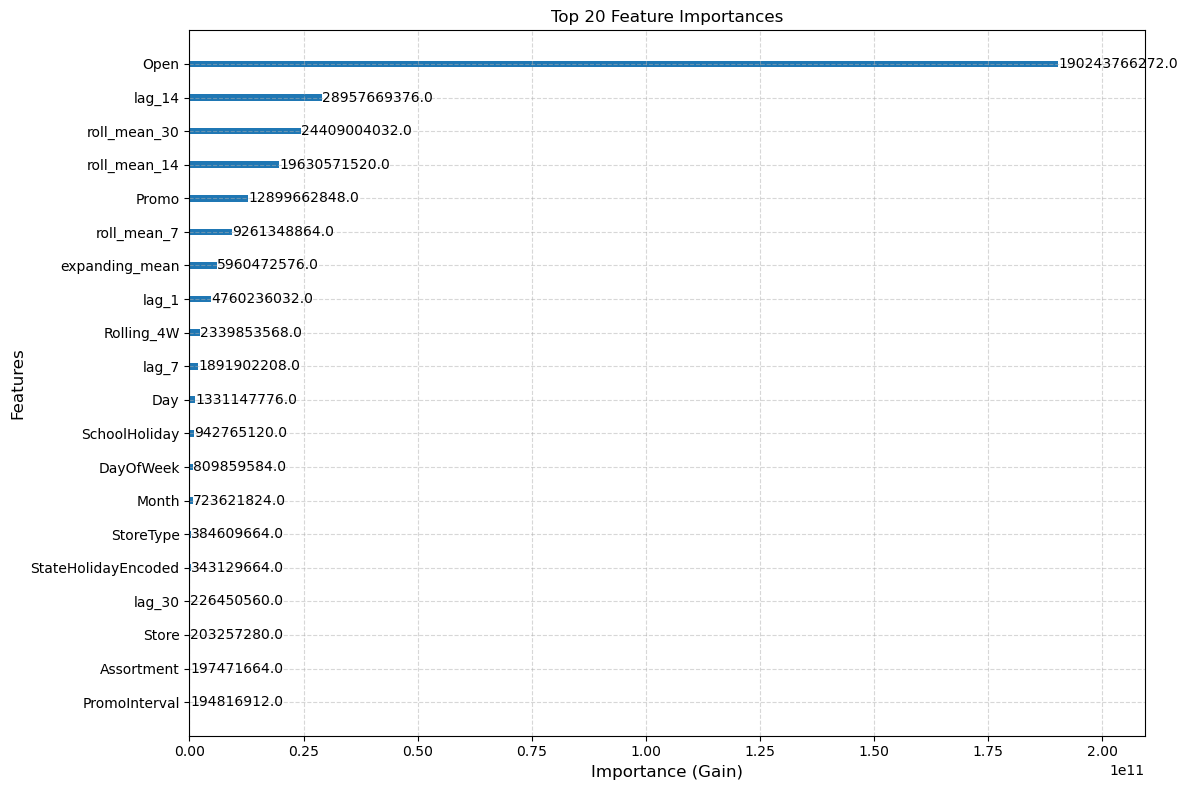

In [29]:

import matplotlib.pyplot as plt
import xgboost as xgb

# Create plot
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(
    model,
    ax=ax,
    max_num_features=20,
    importance_type='gain',  # 'gain' shows how much each feature contributes
    title='Top 20 Feature Importances'
)

# Add labels and formatting
ax.set_xlabel("Importance (Gain)", fontsize=12)
ax.set_ylabel("Features", fontsize=12)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig("feature_importance.png", dpi=300)
plt.show()


# Feature Importance Summary for Client Reporting
The model's top drivers of weekly store-level sales are consistent with business expectations and validate our feature engineering strategy:

- Open: Most critical feature—sales are only recorded when stores are open. Its dominant importance confirms correct handling of missing or zero sales.
- Lag Features (lag_14, lag_1, lag_7, lag_30): These capture temporal dependencies and weekly seasonality. Their high importance shows that past sales are strong predictors of future demand.
- Rolling Averages (roll_mean_30, roll_mean_14, roll_mean_7, Rolling_4W): These smooth out short-term fluctuations and help the model capture trends. Their contribution confirms that engineered smoothing features are effective.
- Promo: High importance reflects the direct impact of promotions on sales uplift.
- expanding_mean: Captures long-term store performance trends, reinforcing the value of cumulative metrics.
- SchoolHoliday, DayOfWeek, Day: These time-based features help the model adjust for calendar effects and weekly patterns.

✅ Conclusion
The feature importance plot confirms that:
- Our engineered features (lags, rolling means, promo flags) are not just technically sound—they’re business-relevant.
- The model is learning from both short-term and long-term patterns.
- The pipeline is ready for deployment and client presentation.

